# Transfert learning avec TensorFlow

## Introduction

Dans ce notebook, nous allons explorer le concept de transfert learning en utilisant TensorFlow.

### Objectif

L'objectif de ce notebook est de :

1. Comprendre le concept de transfert learning.
2. Implémenter le transfert learning en utilisant un modèle pré-entraîné dans TensorFlow.
3. Affiner le modèle pré-entraîné sur un ensemble de données personnalisé.

### 1. Importation des bibliothèques et chargement des données

Commençons par importer les bibliothèques nécessaires et charger notre ensemble de données. Pour cet exemple, nous utiliserons l'ensemble de données suivant:
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

L'archive contient un fichier .json décrivant les données.
A partir du fichier .json, construisez un dataset Tensorflow. Pour cela :
1. Ouvrez le fichier .json, explorez les données.
2. Les données correspondant aux images contiennent successivement 3 canaux. Réorganisez les dimensions des images pour pouvoir les utiliser dans un dataset.
3. Récupérez les labels. Encodez les en one-hot.
4. Construisez le dataset, et préparez le pour l'entrainement.


In [59]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ships-in-satellite-imagery' dataset.
Path to dataset files: /kaggle/input/ships-in-satellite-imagery


In [60]:
import os
os.listdir(path)

['shipsnet', 'shipsnet.json', 'scenes']

In [88]:
import pandas as pd

df = pd.read_json(path+"/shipsnet.json")

In [89]:
import numpy as np
X = []
for data in df['data']:
  X.append(np.array(data).reshape(80,80,3))

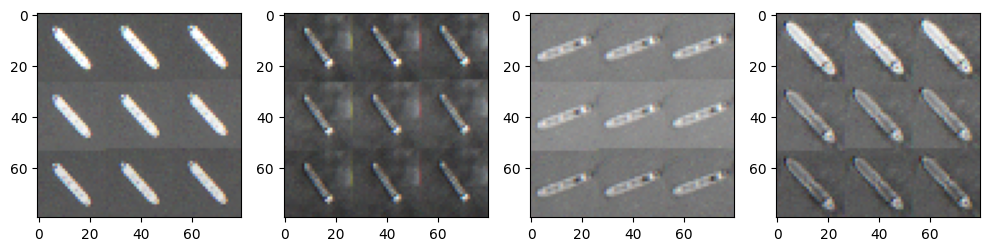

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i])
plt.tight_layout()
plt.show()


In [91]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = encoder.fit_transform(df[['labels']])

In [114]:
dataset = pd.DataFrame({'X':X, 'y':y})

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['X'], dataset['y'], test_size=0.25)

### 2. Chargement du modèle pré-entrainé

Chargez le modèle Tensorflow ResNet50 entrainé sur imagenet en ne gardant que la partie avec couches convolutionnelles (option 'include_top'). Gelez les poids de toutes les couches du réseau (cette partie du modèle final ne sera pas entrainée).

In [67]:
import tensorflow as tf
resNet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

for layer in resNet.layers[-2:]:
  layer.trainable = False

In [68]:
resNet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 3. Construction et compilation du modèle

Intégrez le modèle de ResNet50 dans un modèle final en rajoutant une couche de GlobalAveragePooling2D et deux couches Dense, puis compilez le modèle.

In [69]:
new_model = tf.keras.Sequential()
new_model.add(resNet)
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(256))
new_model.add(tf.keras.layers.Dense(128))
new_model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [70]:
adam = tf.keras.optimizers.Adam()
new_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### 4. Entrainement et visualisation des résultats

Entrainez le modèle final pour 10 epochs, puis visualisez les courbes d'accuracy et de loss.

In [85]:
new_model.fit(X_train, y_train, epochs=10, verbose=1)

ValueError: Invalid dtype: object

### 5. Fine-tuning des paramètres

Décongelez les poids des deux dernières couches de convolution de ResNet50, puis recompilez le modèle final et poursuivez l'entrainement pour 5 epochs de plus

### 6. Evaluez le modèle final sur l'ensemble de test